<a href="https://colab.research.google.com/github/ocriado91/SpocMining/blob/3-first-notebook/notebooks/00_pykep_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to pykep

## Installation from source

We are going to install `pykep` Python package from source according with [these steps](https://esa.github.io/pykep/installation.html):

In [ ]:
# Clone pykep repository if it hasn't been cloned previously.
!if [ ! -d /content/pykep ]; then git clone https://github.com/esa/pykep pykep_source; fi

Cloning into 'pykep_source'...
remote: Enumerating objects: 11876, done.
remote: Counting objects: 100% (461/461), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 11876 (delta 268), reused 397 (delta 240), pack-reused 11415
Receiving objects: 100% (11876/11876), 58.24 MiB | 16.16 MiB/s, done.
Resolving deltas: 100% (7699/7699), done.
Updating files: 100% (2531/2531), done.


### a) Install Keplerian Toolbox library

In [ ]:
# Create build folder and move into it
%mkdir /content/pykep_source/build/
%cd /content/pykep_source/build/

# Run CMake
!cmake -DBoost_NO_BOOST_CMAKE=ON \
    -DPYKEP_BUILD_KEP_TOOLBOX=yes \
    -DPYKEP_BUILD_PYKEP=no \
    -DPYKEP_BUILD_SPICE=yes \
    -DPYKEP_BUILD_TESTS=yes \
    -DCMAKE_INSTALL_PREFIX=/usr/local/ \
    -DCMAKE_PREFIX_PATH=/usr/local/ \
    -DCMAKE_BUILD_TYPE=Release \
    ../;

# And execute make
!cmake  --build . --target install

/content/pykep_source/build
CMake Deprecation Warning at CMakeLists.txt:5 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- System name: 
-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- '-fdiagnostics-color=auto': flag is supported by the compiler, enabling.
-- '-Waddress-of-packed-member': debug flag is supported by the com

### b) Installation pykep Python package

In [ ]:
# Create build pykep folder and move into it
%mkdir /content/pykep_source/build_pykep
%cd /content/pykep_source/build_pykep

# Run CMake with pykep building flags enabled
!cmake -DBoost_NO_BOOST_CMAKE=ON \
    -DPYKEP_BUILD_KEP_TOOLBOX=no \
    -DPYKEP_BUILD_PYKEP=yes \
    -DPYKEP_BUILD_TESTS=no \
    -DCMAKE_INSTALL_PREFIX=/usr/local/ \
    -DCMAKE_PREFIX_PATH=/usr/local/ \
    -DCMAKE_BUILD_TYPE=Release \
    ../;
# And execute make
!make install

/content/pykep_source/build_pykep
CMake Deprecation Warning at CMakeLists.txt:5 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- System name: 
-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- '-fdiagnostics-color=auto': flag is supported by the compiler, enabling.
-- '-Waddress-of-packed-member': debug flag is supported by t

## Install extra packages

In [ ]:
!pip install imageio

# Imports

In [ ]:
import numpy as np
import polars as pl
import pykep as pk

# Plotting
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image, display

/usr/local/lib/python3.10/dist-packages/pykep/util/gravity_spherical_harmonic.py:156: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _calculate_normalisation_parameters(n_max):


# Constants

In [ ]:
# Start and end epochs
T_START = pk.epoch_from_iso_string("30190302T000000")
T_END = pk.epoch_from_iso_string("30240302T000000")

# Cavendish constant (m^3/s^2/kg)
G = 6.67430e-11

# Sun_mass (kg)
SM = 1.989e30

# Mass and Mu of the Trappist-1 star
MS = 8.98266512e-2 * SM
MU_TRAPPIST = G * MS

# DV per fuel [m/s]
DV_per_fuel = 10000

# Maximum time to fully mine an asteroid
TIME_TO_MINE_FULLY = 30

# Input data

In [ ]:
!wget https://api.optimize.esa.int/data/spoc/mining/candidates.txt

--2024-04-23 06:48:05--  https://api.optimize.esa.int/data/spoc/mining/candidates.txt
Resolving api.optimize.esa.int (api.optimize.esa.int)... 195.169.140.114
Connecting to api.optimize.esa.int (api.optimize.esa.int)|195.169.140.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2250000 (2.1M) [text/plain]
Saving to: ‘candidates.txt’

candidates.txt      100%[===================>]   2.15M  1.34MB/s    in 1.6s    

2024-04-23 06:48:08 (1.34 MB/s) - ‘candidates.txt’ saved [2250000/2250000]



In [ ]:
# Read asteroid candidates file
data = pl.read_csv("candidates.txt",
                   separator=" ")

# Set custom headers
HEADER = ["ID",
          "Semi-major axis [m]",
          "Eccentricity",
          "Inclination [rad]",
          "Ascending Node [rad]",
          "Argument of Periapsis [rad]",
          "True Anomaly [rad]",
          "Mass [0 to 1]",
          "Material Type"]
data.columns = HEADER

# Show head
data.head()

ID,Semi-major axis [m],Eccentricity,Inclination [rad],Ascending Node [rad],Argument of Periapsis [rad],True Anomaly [rad],Mass [0 to 1],Material Type
f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,3.0835e10,0.008338,0.079912,3.912543,5.042492,2.617431,0.65811,3.0
2.0,2.3826e10,0.006097,0.006188,4.83121,4.589027,2.075072,0.964783,1.0
3.0,3.0512e10,0.001916,0.072551,2.277854,3.250898,1.168246,0.451917,0.0
4.0,2.9867e10,0.000553,0.013222,3.530913,4.200775,3.918279,0.668809,2.0
5.0,3.3090e10,0.004041,0.103529,2.281561,5.481973,5.145668,0.403246,2.0


# Transform input data to Planet objects

In [ ]:
def transform_to_planet(asteroid_data) -> list:
  asteroids = []
  for idx in range(len(asteroid_data["ID"])):
    asteroid = pk.planet.keplerian(
      T_START,
      # Orbital elements
      (
          asteroid_data[idx]["Semi-major axis [m]"].to_list()[0],
          asteroid_data[idx]["Eccentricity"].to_list()[0],
          asteroid_data[idx]["Inclination [rad]"].to_list()[0],
          asteroid_data[idx]["Ascending Node [rad]"].to_list()[0],
          asteroid_data[idx]["Argument of Periapsis [rad]"].to_list()[0],
          asteroid_data[idx]["True Anomaly [rad]"].to_list()[0]
      ),
      MU_TRAPPIST,
      G * asteroid_data[idx]["Mass [0 to 1]"].to_list()[0],
      1,
      1.1,
      "Asteroid " + str(int(asteroid_data[idx]["ID"].to_list()[0]))
    )
    asteroids.append(asteroid)
  return asteroids

asteroids = transform_to_planet(data)

# Plot asteroids

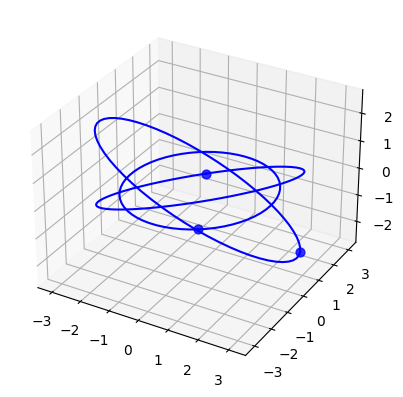

In [ ]:
_, axes = plt.subplots(subplot_kw={'projection': '3d'})
for i in range(3):
  asteroid = asteroids[i]
  pk.orbit_plots.plot_planet(asteroid,
                             axes=axes,
                             t0=T_START,
                             color='b')

<ipython-input-11-e62e0a89ac93>:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


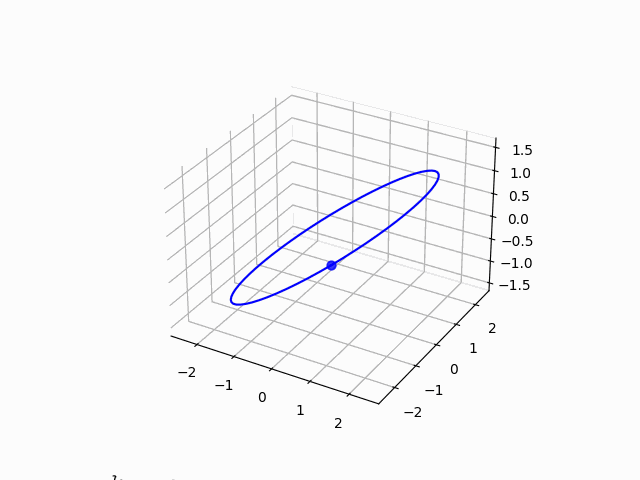

In [ ]:
SELECTED_ASTEROID_ID = 140
source_asteroid = data.filter(pl.col("ID") == SELECTED_ASTEROID_ID)

# Filter by elevation
filtered_asteroids = data.filter(pl.col("Inclination [rad]") < 0.03)

# Transform to Pykep's planet object
filtered_asteroids_planets = transform_to_planet(filtered_asteroids)

frames = []
count = 0

_, axes = plt.subplots(subplot_kw={'projection': '3d'})
for t in [T_START, pk.epoch_from_iso_string("30190303T000000")]:
  for i in range(2):
    asteroid = filtered_asteroids_planets[i]
    ax = pk.orbit_plots.plot_planet(asteroid,
                                    axes=axes,
                                    t0=t,
                                    color='b')

    # Save each frame as an image
    filename = f'frame_{count}.png'
    plt.savefig(filename)
    plt.close()
    frames.append(filename)
    count += 1

# Convert frames to GIF
images = []
for filename in frames:
  images.append(imageio.imread(filename))

imageio.mimsave('orbit_animation.gif', images)

# Show gif
display(Image(open('orbit_animation.gif','rb').read()))